In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_squared_error
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
import os
import glob
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors
from sklearn import datasets, linear_model, metrics

from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

pd.set_option('display.max_colwidth', None)

np.random.seed(0)

In [3]:
# converts dataframe into numpy array of correct shape
def convert(df: pd.DataFrame, frame_size=10):
    x = np.asarray(df.iloc[:, 1]).reshape(-1, frame_size)
    return x

In [4]:
######################## Load Model from .joblib file ####
from joblib import dump,load
reg = load('flowSenseRegressor.joblib')

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DummyRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.24.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator GradientBoostingRegressor from version 0.24.2 when using version 1.0.1. This might 

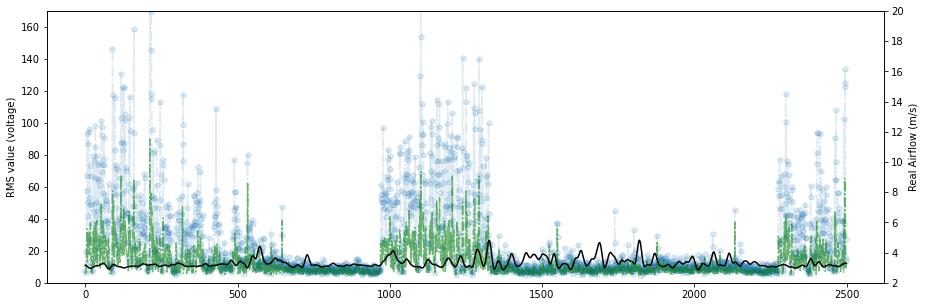

In [155]:
######## Generate graph for submission showing actual airflow, low frequency component, and ambient noise component ####

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
l2, = ax1.plot(rms, 'p-.', alpha = 0.15)
l0, = ax1.plot(actual, 'g-.', alpha = 0.55)
l1, = ax2.plot(amb, 'k-', alpha = 1.0)

# Put a legend to the right of the current axis
#plt.legend((l0, l1, l2), ('Low Frequency Component of Noise', 'Actual Airflow', 'Ambient Noise'), shadow=True, loc='upper right')
ax2.set_ylabel("Real Airflow (m/s)")
ax2.set_ylim(2, 20)
ax1.set_ylabel("RMS value (voltage)")
ax1.set_ylim(0, 170)
fig1.set_size_inches(15, 5, forward=True)
fig1.patch.set_facecolor('white')
plt.savefig("fig3.png", bbox_inches="tight")

[ 22.          49.5354      99.17        58.527      137.4191
  31.7025     352.7         93.015      174.           8.03
  31.02823711]


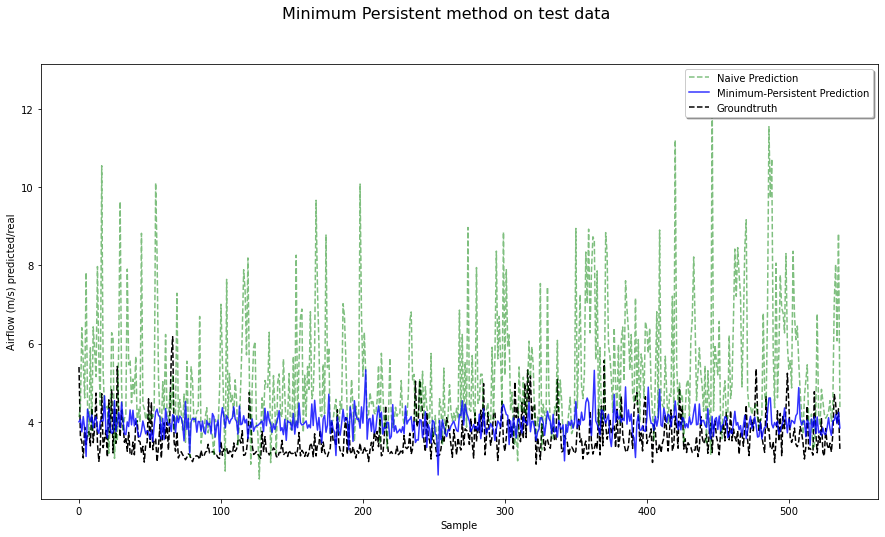

In [9]:
######################## IMPLEMENTING PERSISTENT MINIMUM SCHEME AND TESTING ON AMBIENT DATASET ####

def avg(lst):
    return sum(lst) / len(lst)

def getPersistentMinimum(inp, num=5, epsilon=0.5):
    window = [inp[0]]
    for i in range(1, len(inp)):
        if abs(inp[i] - avg(window)) > epsilon: #if this prediction deviates from the running mean by more than epsilon...
            window = [inp[i]]    #start over, reset our window size
        else:
            window.append(inp[i])
        if len(window) == int(num):
            return avg(window)
    return 0

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "ConversationAmbientNoiseWithGroundtruth.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

print(df[0])

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []

for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(8)
fig1.suptitle('Minimum Persistent method on test data', fontsize=16)
l1, = ax1.plot(groundtruths, 'k--', alpha = 1)
l0, = ax1.plot(predictions, 'g--', alpha = 0.5)
l2, = ax1.plot(minimumPersistent, 'b-', alpha = 0.8)
#l3, = ax1.plot(totalMinimum, 'p-', alpha = 0.2)
ax1.legend((l0, l2, l1), ('Naive Prediction', 'Minimum-Persistent Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [11]:
######################## TESTING DIFFERENT CANDIDATE PARAMETERS FOR MPS ####

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "ConversationAmbientNoiseWithGroundtruth.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

def MPS(s, n, e):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        if i % s == 0:
            tempPred.sort()
            minimumPersistent.append(getPersistentMinimum(tempPred, num = n, epsilon = e))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}".format(s,n,e))
    print("Standard MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("MinimumPersistent MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

#num samples = 15, window size 5, epsilon 0.75
samples = 15
n = 5
e = 0.75
MPS(samples, n, e)

#num samples = 25, window size 5, epsilon 0.75
samples = 25
n = 5
e = 0.75
MPS(samples, n, e)

#num samples = 15, window size 5, epsilon 0.5
samples = 15
n = 5
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 5, epsilon 0.5
samples = 25
n = 5
e = 0.50
MPS(samples, n, e)

#num samples = 15, window size 7, epsilon 0.5
samples = 15
n = 7
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 7, epsilon 0.5
samples = 25
n = 7
e = 0.50
MPS(samples, n, e)

#num samples = 15, window size 3, epsilon 0.5
samples = 15
n = 3
e = 0.50
MPS(samples, n, e)

#num samples = 25, window size 3, epsilon 0.5
samples = 25
n = 3
e = 0.50
MPS(samples, n, e)

Num Samples: 15, Window Size: 5, epsilon: 0.75
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 1.0590401984329256

Num Samples: 25, Window Size: 5, epsilon: 0.75

/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)



Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.35643697620236203

Num Samples: 15, Window Size: 5, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 2.184722412172042

Num Samples: 25, Window Size: 5, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.3673769729532772



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-o

Num Samples: 15, Window Size: 7, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 5.024700824959137

Num Samples: 25, Window Size: 7, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.973247874924996



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


Num Samples: 15, Window Size: 3, epsilon: 0.5
Standard MSE: 6.570235281067255
MinimumPersistent MSE: 0.5963782153159957

Num Samples: 25, Window Size: 3, epsilon: 0.5
Standard MSE: 5.544224957952375
MinimumPersistent MSE: 0.7284577456518158



/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/utils/validation.py:738: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  array = np.asarray(array, order=order, dtype=dtype)
/Users/adam/miniforge3/lib/python3.8/site-packages/sklearn/metrics/_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


9225
[ 22.          49.5354      99.17        58.527      137.4191
  31.7025     352.7         93.015      174.           8.03
  31.02823711]


/Users/adam/miniforge3/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


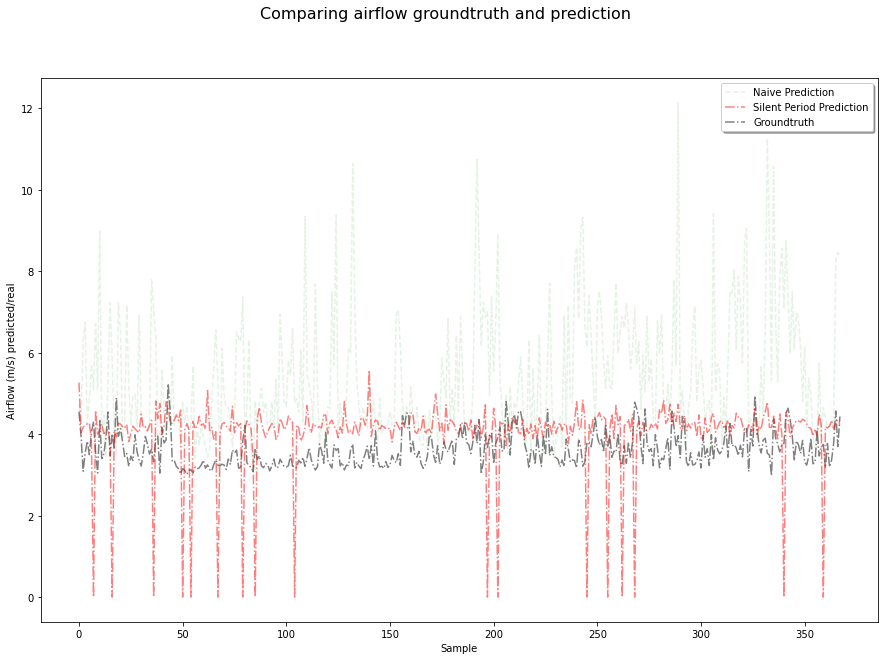

In [12]:
######################## IMPLEMENTING SILENT PERIODS SCHEME AND TESTING ON AMBIENT DATASET ####

def getForSilentPeriods(inp, rms, threshold=15):
    silentPreds = []
    for i in range(0, len(inp)):
        if rms[i] < threshold:   # if it was silent during this prediction
            silentPreds.append(inp[i])   # then add this to the list
    if len(silentPreds) > 0:
        return avg(silentPreds)
    else:
        return 0
    
def getForSilentPeriodsWithAveraging(inp, rms, threshold=15):
    if avg(rms) < threshold:   # if it was silent during this prediction
        return avg(inp)
    else:
        return 0

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "ConversationAmbientNoiseWithGroundtruth.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)
print(df.shape[0])

print(df[0])
indices = range(10000,15000)

predictions = []
silentPeriods = []
silentPeriodsAvg = []
groundtruths = []
rms = []
tempPred = []
tempGround = []

for i in range(1, df.shape[0]):
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    rms.append(df[i][-1])
    
    if i % 25 == 0:
        silentPeriods.append(getForSilentPeriods(tempPred, rms))
        silentPeriodsAvg.append(getForSilentPeriodsWithAveraging(tempPred, rms))
        predictions.append(sum(tempPred)/len(tempPred))
        groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []
        rms = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.1)
l2, = ax1.plot(silentPeriods, 'r-.', alpha = 0.5)
ax1.legend((l0, l2, l1), ('Naive Prediction', 'Silent Period Prediction', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

In [13]:
###### FILTER BY SILENT THRESHOLDS AND GET WHAT PERCENTAGES OF THE DATA FALL BELOW THIS THRESHOLD

def filtering(threshold):
    return df[df[:,-1]<threshold]
    
print("Size of input: ", len(df))
print("Size of filtered by RMS 15: ", len(filtering(15)))
print("Size of filtered by RMS 25: ", len(filtering(25)))
print("Size of filtered by RMS 50: ", len(filtering(50)))
print("Size of filtered by RMS 70: ", len(filtering(70)))

##Percentages

print("Percent with RMS value below 15: ", len(filtering(15))/len(df))
print("Percent with RMS value below 25: ", len(filtering(25))/len(df))
print("Percent with RMS value below 50: ", len(filtering(50))/len(df))
print("Percent with RMS value below 70: ", len(filtering(70))/len(df))


Size of input:  9225
Size of filtered by RMS 15:  2647
Size of filtered by RMS 25:  4126
Size of filtered by RMS 50:  6819
Size of filtered by RMS 70:  8055
Percent with RMS value below 15:  0.2869376693766938
Percent with RMS value below 25:  0.44726287262872627
Percent with RMS value below 50:  0.7391869918699187
Percent with RMS value below 70:  0.8731707317073171


In [14]:
######################## TESTING DIFFERENT CANDIDATE PARAMETERS FOR SILENT THRESHOLD ####

def SD(s, t):
    predictions = []
    silentPeriods = []
    groundtruths = []
    rms = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        rms.append(df[i][-1])

        if i % 25 == 0:
            silentPeriods.append(getForSilentPeriods(tempPred, rms, threshold=t))
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
            rms = []
    print("Num Samples: {}, Threshold: {}".format(s,t))
    print("Standard MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    
    groundtruths = np.array(groundtruths, dtype=object)
    silentPeriods = np.array(silentPeriods, dtype=object)
    
    #get rid of any failed predictions
    indices = np.where(silentPeriods == 0)
    groundtruthsFilt = np.delete(groundtruths, indices, None)
    silentPeriodsFilt = np.delete(silentPeriods, indices, None)
    print("SilentPeriods MSE: {}".format(mean_squared_error(silentPeriodsFilt, groundtruthsFilt)))
    print("")

#num samples = 15, threshold = 15
samples = 15
t = 15
SD(samples, t)

#num samples = 15, threshold = 15
t = 25
SD(samples, t)

#num samples = 15, threshold = 15
t = 50
SD(samples, t)

#num samples = 15, threshold = 15
t = 70
SD(samples, t)

#num samples = 25, threshold = 15
samples = 25
t = 15
SD(samples, t)

#num samples = 25, threshold = 15
t = 25
SD(samples, t)

#num samples = 25, threshold = 15
t = 50
SD(samples, t)

#num samples = 25, threshold = 15
t = 70
SD(samples, t)

Num Samples: 15, Threshold: 15
Standard MSE: 5.544224957952375
SilentPeriods MSE: 0.6078398045157247

Num Samples: 15, Threshold: 25
Standard MSE: 5.544224957952375
SilentPeriods MSE: 0.6959770456752221

Num Samples: 15, Threshold: 50
Standard MSE: 5.544224957952375
SilentPeriods MSE: 2.6221608773385445

Num Samples: 15, Threshold: 70
Standard MSE: 5.544224957952375
SilentPeriods MSE: 4.119544790061304

Num Samples: 25, Threshold: 15
Standard MSE: 5.544224957952375
SilentPeriods MSE: 0.6078398045157247

Num Samples: 25, Threshold: 25
Standard MSE: 5.544224957952375
SilentPeriods MSE: 0.6959770456752221

Num Samples: 25, Threshold: 50
Standard MSE: 5.544224957952375
SilentPeriods MSE: 2.6221608773385445

Num Samples: 25, Threshold: 70
Standard MSE: 5.544224957952375
SilentPeriods MSE: 4.119544790061304



[ 22.          49.5354      99.17        58.527      137.4191
  31.7025     352.7         93.015      174.           8.03
  31.02823711]


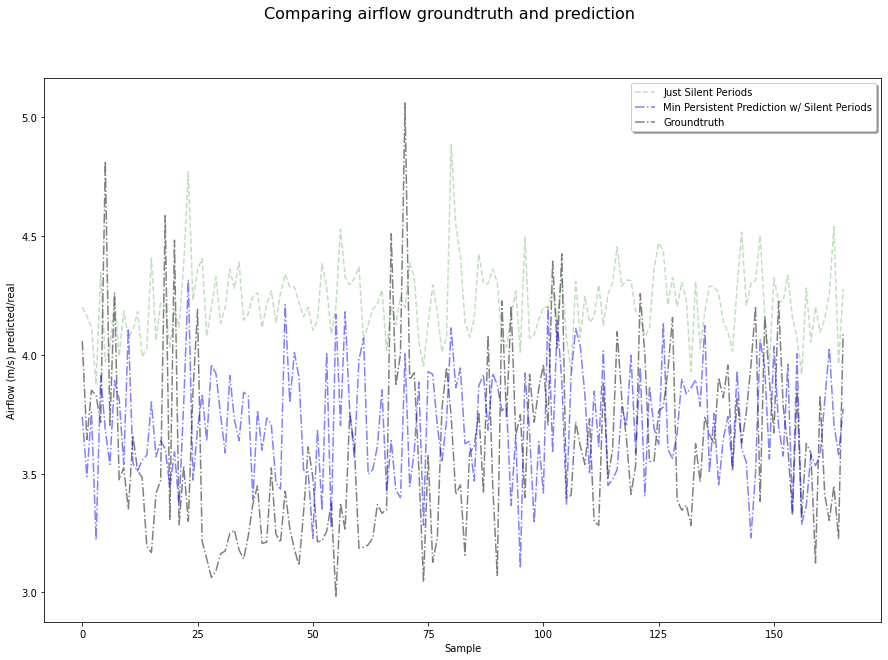

MinimumPersistent MSE:  0.22088407973759724


In [15]:
######################## IMPLEMENTING PERSISTENT MINIMUM SCHEME W SILENT PERIODS AND TESTING ON AMBIENT DATA ####

def avg(lst):
    return sum(lst) / len(lst)

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "ConversationAmbientNoiseWithGroundtruth.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

print(df[0])
indices = range(15000)

predictions = []
minimumPersistent = []
totalMinimum = []
groundtruths = []
tempPred = []
tempGround = []
threshold = 15

for i in range(1, df.shape[0]):
    if(df[i][-1] > threshold): # if rms value is larger than threshold, totally skip this data point
        tempGround.append(df[i][-2])
        continue
    X = df[i,:6]
    tempPred.append(reg.predict(X.reshape(1, -1)))
    tempGround.append(df[i][-2])
    if i % 15 == 0:
        tempPred.sort()
        perMin = getPersistentMinimum(tempPred, num=3)
        if (perMin != 0):
            minimumPersistent.append(perMin)
            totalMinimum.append(tempPred[0])
            predictions.append(sum(tempPred)/len(tempPred))
            groundtruths.append(sum(tempGround)/len(tempGround))
        tempPred = []
        tempGround = []

fig1, ax1 = plt.subplots()
fig1.set_figwidth(15)
fig1.set_figheight(10)
fig1.suptitle('Comparing airflow groundtruth and prediction', fontsize=16)
l1, = ax1.plot(groundtruths, 'k-.', alpha = 0.5)
l0, = ax1.plot(predictions, 'g--', alpha = 0.25)
l2, = ax1.plot(minimumPersistent, 'b-.', alpha = 0.5)
ax1.legend((l0, l2, l1), ('Just Silent Periods', 'Min Persistent Prediction w/ Silent Periods', 'Groundtruth'), loc='upper right', shadow=True)
ax1.set_xlabel("Sample")
ax1.set_ylabel("Airflow (m/s) predicted/real")
plt.show()

print("MinimumPersistent MSE: ", mean_squared_error(minimumPersistent,groundtruths))

In [16]:
######################## TESTING DIFFERENT CANDIDATE PARAMETERS FOR MPS AND SILENT THRESHOLD ####

data_dir = Path("../../Datasets/Smartphone/RealWorld")
df1 = pd.read_csv(data_dir / "ConversationAmbientNoiseWithGroundtruth.csv", low_memory=False, names= ['frequency','amplitude'] , index_col = False)
df1 = df1[df1['frequency'] != "clocktime"]
df1 = df1.dropna()

df = convert(df1, frame_size=11)

def MPS(s, n, e, t):
    predictions = []
    minimumPersistent = []
    groundtruths = []
    tempPred = []
    tempGround = []

    for i in range(1, df.shape[0]):
        if(df[i][-1] > t): # if rms value is larger than threshold, totally skip this data point
            tempGround.append(df[i][-2])
            continue
        X = df[i,:6]
        tempPred.append(reg.predict(X.reshape(1, -1)))
        tempGround.append(df[i][-2])
        if i % 15 == 0:
            tempPred.sort()
            perMin = getPersistentMinimum(tempPred, num=3)
            if (perMin != 0):
                minimumPersistent.append(perMin)
                totalMinimum.append(tempPred[0])
                predictions.append(sum(tempPred)/len(tempPred))
                groundtruths.append(sum(tempGround)/len(tempGround))
            tempPred = []
            tempGround = []
    print("Num Samples: {}, Window Size: {}, epsilon: {}, RMS not-silent threshold: {}".format(s,n,e,t))
    print("Silent Periods MSE: {}".format(mean_squared_error(predictions, groundtruths)))
    print("MinimumPersistent AND SilentPeriods MSE: {}".format(mean_squared_error(minimumPersistent, groundtruths)))
    print("")

#num samples = 15, window size 3, epsilon 0.75, threshold 15
samples = 15
n = 3
e = 0.75
t = 15
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 15
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 25
e = 0.75
t = 25
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 25
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 50
e = 0.75
t = 50
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 50
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 70
e = 0.75
t = 70
MPS(samples, n, e, t)

#num samples = 15, window size 3, epsilon 0.75, threshold 70
e = 0.5
MPS(samples, n, e, t)


#num samples = 15, window size 5, epsilon 0.75, threshold 15
samples = 15
n = 5
e = 0.75
t = 15
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 15
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 25
e = 0.75
t = 25
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 25
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 50
e = 0.75
t = 50
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 50
e = 0.5
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 70
e = 0.75
t = 70
MPS(samples, n, e, t)

#num samples = 15, window size 5, epsilon 0.75, threshold 70
e = 0.5
MPS(samples, n, e, t)



Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 15
Silent Periods MSE: 0.542299233629999
MinimumPersistent AND SilentPeriods MSE: 0.22088407973759724

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 15
Silent Periods MSE: 0.542299233629999
MinimumPersistent AND SilentPeriods MSE: 0.22088407973759724

Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 25
Silent Periods MSE: 0.7450007544215795
MinimumPersistent AND SilentPeriods MSE: 0.3045717785990041

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 25
Silent Periods MSE: 0.7450007544215795
MinimumPersistent AND SilentPeriods MSE: 0.3045717785990041

Num Samples: 15, Window Size: 3, epsilon: 0.75, RMS not-silent threshold: 50
Silent Periods MSE: 2.9131105130593453
MinimumPersistent AND SilentPeriods MSE: 0.39060428836043826

Num Samples: 15, Window Size: 3, epsilon: 0.5, RMS not-silent threshold: 50
Silent Periods MSE: 2.9131105130593453
M